In [41]:
import os, numpy as np, matplotlib.pyplot as plt
folder = "/Users/raaghav/Downloads/final" # folder containing the data

In [43]:
# Now we try to load the images and their corresponding labels into memory

def load_data(X, y):
    for f in os.listdir(folder):
        class_path = os.path.join(folder,f)
        if not os.path.isdir(class_path):
            continue 
        for file in os.listdir(f"{folder}/{f}"):
            img = plt.imread(f"{folder}/{f}/{file}")
            X.append(img)

            # The most obvious choice for the label is the class (folder) name
            # label = int(f)

            # [Q1] But we dont use it here why? Why is it an array of 10 elements?
            # Clue: Lookup one hot encoding
            # Read up on Cross Entropy Loss
            #--> Since one hot encoding requires a one-hot vector(i.e 10 elements for 10 categories)
            #--> Cross entropy loss expects probabilities (not class indices).
            label = [0] * 10
            label[int(f)] = 1 # Why is this array the label and not a numeber?

            y.append(label)
            
        print(f"Loaded {f} class")

X, y = [], []
load_data(X, y)

# [Q2] Why convert to numpy array?
"""--> more memory efficient than python lists
--> allows for vectorisation"""
"""
.
convert x and y to numpy arrays here
.
"""
X = np.array(X)
y = np.array(y)

X = X[:, :,:, 0] 
# [Q3] Why are we doing this and what does this type of slicing result in?
# --> this results in us getting only the zeroeth index or first channel,i.e it discards colour and keeps grayscale intensity 
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # [Q4] Why are we reshaping the data?
print("After reshaping")
print(X.shape, y.shape)
print(X[0], y[0])

Loaded 9 class
Loaded 0 class
Loaded 7 class
Loaded 6 class
Loaded 1 class
Loaded 8 class
Loaded 4 class
Loaded 3 class
Loaded 2 class
Loaded 5 class
After reshaping
(60000, 784) (60000, 10)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.      

In [44]:
class NN:
    def __init__(self, input_neurons, hidden_neurons, output_neurons, learning_rate, epochs):
        """
        Class Definition
        
        We use a class because it is easy to visualize the process of training a neural network
        It's also easier to resuse and repurpose depending on the task at hand

        We have a simple neural network, with an input layer, one hidden (middle) layer and an output layer

        input_neurons: Number of neurons in the input layer
        hidden_neurons: Number of neurons in the hidden layer
        output_neurons: Number of neurons in the output layer
        learning_rate: The rate at which the weights are updated [Q5] What is the learning rate?
        epochs: Number of times the model will train on the entire dataset 
        """

        self.input_neurons = input_neurons
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.epochs = epochs

        self.lr = learning_rate

        """
        Weights and Biases

        At this point you should know what weights and biases are in a neural network and if not, go check out the 3blue1brown video on Neural Networks
        What matters here is however the matrix dimensions of the weights and biases

        [Q6] Why are the dimensions of the weights and biases the way they are?
        
        Try to figure out the dimensions of the weights and biases for the hidden and output layers
        Try to see what equations represent the forward pass (basically the prediction)
        And then, try to see if the dimensions of the matrix multiplications are correct

        Note: The bias dimensions may not match. Look up broadcasting in numpy to understand
        [Q7] What is broadcasting and why do we need to broadcast the bias?
        """

        # Ideally any random set of weights and biases can be used to initialize the network
        # self.wih = np.random.randn(hidden_neurons, input_neurons)

        # [Q8] What is np.random.randn? What's the shape of this matrix?

        # Optional: Try to figure out why the weights are initialized this way
        # Note: You can just use the commented out line above if you don't want to do this

        self.wih = np.random.randn(hidden_neurons, input_neurons) * np.sqrt(2/input_neurons)
        self.bih = np.zeros((hidden_neurons, 1))

        self.who = np.random.randn(output_neurons, hidden_neurons) * np.sqrt(2/hidden_neurons)
        self.bho = np.zeros((output_neurons, 1))

    # Activation Functions and their derivatives
    # [Q9] What are activation functions and why do we need them?

    def relu(self, z):
        """
        Implementation of the RELU function
        z: (n, 1)
        returns (n, 1)
        """
        return z * (z > 0)

    def sigmoid(self, z):
        """
        Implementation of the Sigmoid function
        z: (n, 1)
        returns (n, 1)
        """
        return 1 / (1 + np.exp(-z))

    def relu_derivative(self, z):
        """
        Implementation of the RELU derivative function
        z: (n, 1)
        returns (n, 1)
        """
        return 1 * (z > 0)

    def sigmoid_derivative(self, z):
        """
        Implementation of the Sigmoid derivative function
        z: (n, 1)
        returns (n, 1)
        """
        return z * (1 - z)

    # [Q10] What is the softmax function and why do we need it? Read up on it
    def softmax(self, z):
        """
        Implementation of the Softmax function
        z: (n, 1)
        returns (n, 1)
        """
        return np.exp(z) / np.sum(np.exp(z), axis=0)

    def softmax_derivative(self, z):
        """
        Implementation of the Softmax derivative function
        z: (n, 1)
        returns (n, 1)
        """
        return z * (1 - z)

    # Loss Functions and their derivatives
    # [Q11] What are loss functions and why do we need them?

    def mean_squared_error(self, y, y_hat):
        """
        Implementation of the Mean Squared Error function
        y: (10, n)
        y_hat: (10, n)
        returns (1, n)
        """
        return np.mean((y - y_hat) ** 2, axis=0)

    def cross_entropy_loss(self, y, y_hat):
        """
        Implementation of the Cross Entropy Loss function
        y: (10, n)
        y_hat: (10, n)
        returns (1, n)
        """

        # Implement the cross entropy loss function here and return it
        # Keep the dimensions of the input in mind when writing the code

        # [Code Goes Here]

        eps = 1e-12
        y_hat = np.clip(y_hat, eps, 1 - eps)  # avoid log(0)
        return -np.sum(y * np.log(y_hat)) / y.shape[1]

    def mean_squared_error_derivative(self, y, y_hat):
        """
        Implementation of the Mean Squared Error derivative function
        y: (10, n)
        y_hat: (10, n)
        returns (10, n)
        """
        return y_hat - y

    def cross_entropy_derivative(self, y, y_hat):
        """
        Implementation of the Cross Entropy Loss derivative function
        y: (10, n)
        y_hat: (10, n)
        returns (10, n)
        """

        # Implement the cross entropy loss derivative function here and return it
        # Note: The derivative of the CEL is usually taken with respect to the softmax input not output so keep that in mind while writing

        # [Code Goes Here]

        return (y_hat - y)

    # Forward propagation
    def forward(self, input_list):
        """
        Implementation of the Forward Pass
        input_list: (784, n)        - n is the number of images
        returns (10, n)              - n is the number of images
    
        Now we come to the heart of the neural network, the forward pass
        This is where the input is passed through the network to get the output

        [Q12] What does the output choice we have here mean? It's an array of 10 elements per image, but why?
        """

        inputs = np.array(input_list, ndmin=2).T
        inputs = inputs - np.mean(inputs) # [Q13] Why are we subtracting the mean of the inputs?


        
        # To get to the hidden layer:
        # Multiply the input with the weights and adding the bias
        # Apply the activation function (relu in this case)

        # [Code Goes Here]
        hidden_inputs = np.dot(self.wih, inputs) + self.bih
        hidden_outputs = self.relu(hidden_inputs)
        

        # To get to the output layer:
        # Multiply the hidden layer output with the weights and adding the bias
        # Apply the activation function (softmax in this case)
        # [Q14] Why are we using the softmax function here?

        # [Code Goes Here]
        final_inputs = np.dot(self.who, hidden_outputs) + self.bho
        final_outputs = self.softmax(final_inputs)
        

        # Return it

        # [Code Goes Here]
        return final_outputs
        

    # Back propagation
    def backprop(self, inputs_list, targets_list):
        """
        Implementation of the Backward Pass
        inputs_list: (784, n)
        targets_list: (10, n)
        returns a scalar value (loss)
        
        This is where the magic happens, the backpropagation algorithm
        This is where the weights are updated based on the error in the prediction of the network

        Now, the calculus involved is fairly complicated, especially because it's being done in matrix form
        However the intuition is simple. 

        Since this is a recruitment stage, most of the function is written out for you, so follow along with the comments
        """

        # Basic forward pass to get the outputs
        # Obviously we need the predictions to know how the model is doing
        # [Q15] Why are we doing a forward pass here instead of just using the outputs from the forward function?
        # Is there any actual reason, or could we just swap it?

        inputs = np.array(inputs_list, ndmin=2).T # (784, n)
        inputs = inputs - np.mean(inputs)
        


        tj = np.array(targets_list, ndmin=2).T # (10, n)

        hidden_inputs = np.dot(self.wih, inputs) + self.bih
        hidden_outputs = self.relu(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs) + self.bho
        yj = self.softmax(final_inputs)

        # Calculating the loss - This is the error in the prediction
        # The loss then is the indication of how well the model is doing, its a useful parameter to track to see if the model is improving

        loss = self.cross_entropy_loss(tj, yj)


        # Updating the weights using Update Rule
        # Now that we have the incorrect predictions, we can update the weights to make the predictions better
        # This is done using the gradient of the loss function with respect to the weights
        # Basically, we know how much the overall error is caused due to individual weights using the chain rule of calculus
        # Since we want to minimise the error, we move in the opposite direction of something like a "derivative" of the error with respect to the weights
        # Calculus therefore helps us find the direction in which we should move to reduce the error
        # A direction means what delta W changes we need to make to make the model better

        # Output Layer - We start with the output layer because we are backtracking how the error is caused
        # Think of it as using the derivatives of each layer while going back


        # For the task, you will be using Cross Entropy Loss

        # Change this to cross entropy loss
        dE_dzo = self.cross_entropy_derivative(tj,yj) # (10,n)
        # Note: the derivative of the CEL is usually taken with respect to the softmax input not output so keep that in mind while writing


        dE_dwho = np.dot(dE_dzo, hidden_outputs.T) / hidden_outputs.shape[1] # dot((10,n) (n,128) = (10,128)
        dE_dbho = np.mean(dE_dzo, axis=1, keepdims=True) # sum((10,n), axis=1) = (10,1)
        
        self.who -= self.lr * dE_dwho
        self.bho -= self.lr * dE_dbho

        # Hidden Layer
        dE_dah = np.dot(self.who.T, dE_dzo) # dot((128,10), (10,n)) = (128,n)
        dE_dzh = dE_dah * self.relu_derivative(hidden_inputs)
        dE_dwih = np.dot(dE_dzh, inputs.T) / inputs.shape[1]
        dE_dbih = np.mean(dE_dzh, axis=1, keepdims=True)


        self.wih -= self.lr * dE_dwih
        self.bih -= self.lr * dE_dbih

        return np.mean(loss)

    def fit(self, inputs_list, targets_list,validation_data, validation_labels):
        """
        Implementation of the training loop
        inputs_list: (784, n)
        targets_list: (10, n)
        validation_data: (784, n)
        validation_labels: (10, n)
        returns train_loss, val_loss

        This is where the training loop is implemented
        We loop over the entire dataset for a certain number of epochs
        We also track the validation loss to see how well the model is generalizing
        [Q16] What is the validation dataset and what do we mean by generalization?

        We also return the training and validation loss to see how the model is improving
        It's a good idea to plot these to see how the model is doing
        """

        train_loss = []
        val_loss = []
        for epoch in range(self.epochs):
            loss = self.backprop(inputs_list, targets_list)
            train_loss.append(loss)
            vloss = self.cross_entropy_loss(validation_labels.T, self.forward(validation_data))
            val_loss.append(np.mean(vloss)) 
            print(f"Epoch: {epoch}, Loss: {loss}, Val Loss: {val_loss[-1]}")

        return train_loss[1:], val_loss[:-1] 

    def predict(self, X):
        outputs = self.forward(X).T
        return outputs

Epoch: 0, Loss: 2.345052103829998, Val Loss: 2.207802519656411
Epoch: 1, Loss: 2.206148331032214, Val Loss: 2.0881321512210205
Epoch: 2, Loss: 2.0863595776421366, Val Loss: 1.9830851297222218
Epoch: 3, Loss: 1.9811754485642266, Val Loss: 1.889810829091333
Epoch: 4, Loss: 1.8877911334383686, Val Loss: 1.8064396162684042
Epoch: 5, Loss: 1.8043620151869475, Val Loss: 1.7316028332604143
Epoch: 6, Loss: 1.7294923161963207, Val Loss: 1.664242715531025
Epoch: 7, Loss: 1.662127526951412, Val Loss: 1.6034544993349633
Epoch: 8, Loss: 1.601363780820653, Val Loss: 1.5484434301858565
Epoch: 9, Loss: 1.5464138194821375, Val Loss: 1.4985253037338975
Epoch: 10, Loss: 1.496561284548252, Val Loss: 1.453068766896672
Epoch: 11, Loss: 1.4511935841553547, Val Loss: 1.4115475655497958
Epoch: 12, Loss: 1.4097810642471944, Val Loss: 1.3735117878757992
Epoch: 13, Loss: 1.3718693047230397, Val Loss: 1.338560612847011
Epoch: 14, Loss: 1.337041412715674, Val Loss: 1.3063545259217053
Epoch: 15, Loss: 1.304955026693

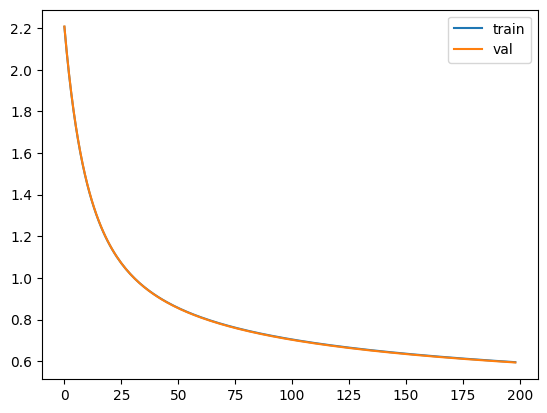

Accuracy: 0.7965


In [50]:
# This is where the class is used to train the model

# The parameters in the model are (input_neurons, hidden_neurons, output_neurons, learning_rate, epochs)
# These parameters aren't the right parameters, so tweak them to get the best results
# Around 70% accuracy is a good end goal (75% is great) but for the recruitment task, 60% is good enough

# [Q17] What are the parameters in the model and what do they mean?

fashion_mnist = NN(784, 256, 10, 0.05, 200)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

# Splitting the data into training, validation and testing in the ratio 70:20:10
X_train, y_train = X[:int(0.7*len(X))], y[:int(0.7*len(X))]
X_val, y_val = X[int(0.7*len(X)):int(0.9*len(X))], y[int(0.7*len(X)):int(0.9*len(X))]
X_test, y_test = X[int(0.9*len(X)):], y[int(0.9*len(X)):]

# Training the model
train_loss,val_loss = fashion_mnist.fit(X_train, y_train,X_val,y_val)


# Plotting the loss
plt.plot(train_loss,label='train')
plt.plot(val_loss,label='val')
plt.legend()
plt.show()

y_pred = fashion_mnist.predict(X_test)

# [Q18] Why are we using argmax here? Why is this output different from the output of the model?
y_pred = np.argmax(y_pred, axis=1)  
y_test = np.argmax(y_test, axis=1)
print(f"Accuracy: {np.mean(y_pred == y_test)}")